In [ ]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

df = r"steam_reviews_clean.parquet"

con = duckdb.connect()
con.execute("SET enable_progress_bar = false;")

## 1. Introduction
Modern video games, particularly big AAA titles, receive continuous feedback from players through online review platforms such as Steam. During controversy periods (like unpopular updates, monetization changes, or technical issues) games often experience sudden/extreme drops in review sentiment which is basically how people are liking the game. But what is it that leads these protests against the game change through the negative reviews?

This study analyzes over 100 million Steam reviews from a ~40GB dataset to investigate the relationship between player engagement and negative sentiment during controversy periods. Rather than focusing specifically on sentiment trends, this analysis examines whether highly engaged players are responsible for negative review spikes, showing how changes in a game can cause backlash in the diehard community.

## 2. Research Question and Hypothesis
### Research Question:
Do highly engaged players (as measured by playtime) leave negative reviews during controversy periods?

### Hypothesis:
Highly engaged players are more likely to leave negative reviews during controversy periods, indicating frustration rather than disengagement.

This hypothesis is motivated by observed patterns in gaming communities from games I have played myself, where long-term players often remain invested in a game despite dissatisfaction with specific updates or changes. Instead, the community comes together to express this dissatisfaction.



## 3. Global Sentiment Trends Over Time (Exploratory Analysis)

Before finding controversy periods, I decided to do look at exploratory analysis of overall sentiment trends over time to validate the time-series reliability of the dataset.

Monthly sentiment was calculated as:

`Positive Rate` = `AVG(voted_up)`

The global sentiment-over-time visualization revealed several important patterns:

- Review volume steadily increased over time, reflecting the growth of the Steam platform
- A noticeable spike in review activity occurred around 2020, likely corresponding to increased gaming during the COVID-19 pandemic as many people picked up video games during this time
- Positive review rates generally stabilized in later years as review volume increased
- Distinct dips in sentiment were observable at specific time periods, suggesting large-scale controversy across games in general, or just for the most reviewed games in the dataset, causing this overall dip

These trends increase confidence in the dataset’s time analysis validity, as the patterns align with real-world gaming trends and platform growth.

Additionally, the presence of sharp sentiment dips supports the methodological approach of defining “controversy periods” as months with significant negative changes in sentiment, which directly motivates the core analysis of player behavior during backlash events. But in order to do this analysis, I am going to look more into the specific game level as we want to look at backlash specific to things caused by the game and not overall steam reviews.

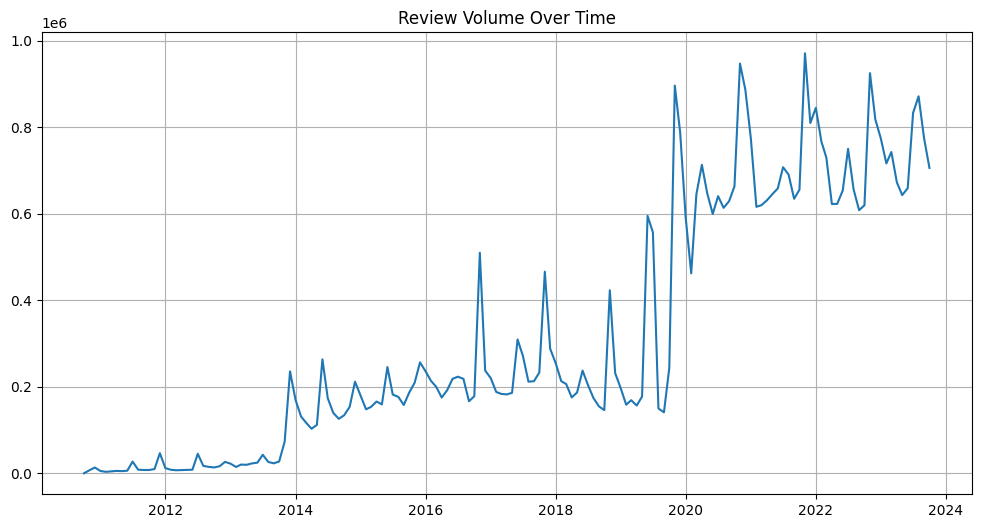

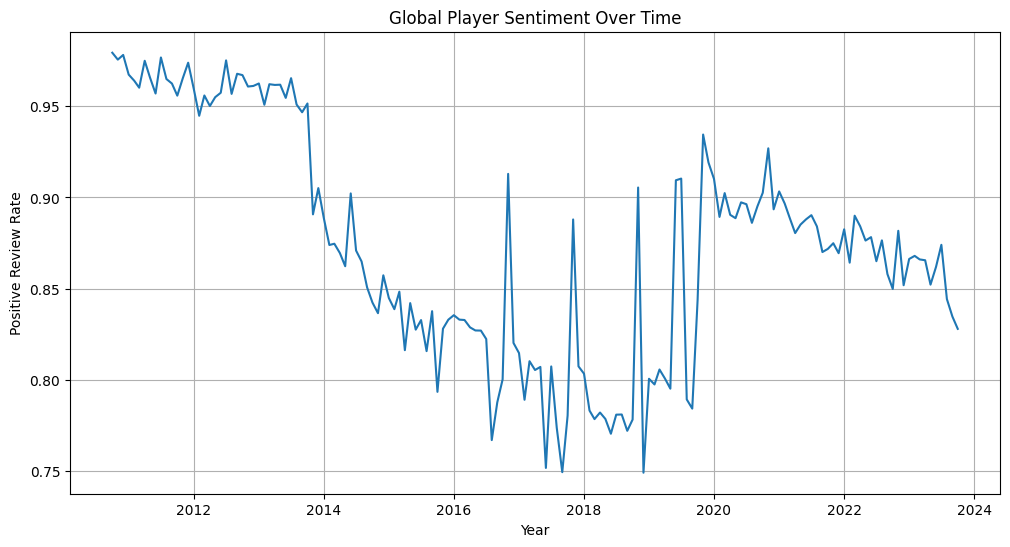

In [21]:
df_reviews_time = con.execute("""
SELECT 
    DATE_TRUNC('month', timestamp_created) AS month,
    COUNT(*) AS review_count
FROM parquet_scan(?)
WHERE timestamp_created < '2023-11-01'
GROUP BY month
ORDER BY month
""", [df]).df()

plt.figure(figsize=(12,6))
plt.plot(df_reviews_time["month"], df_reviews_time["review_count"])
plt.title("Review Volume Over Time")
plt.grid(True)
plt.show()

df_sentiment_time = con.execute("""
SELECT 
    DATE_TRUNC('month', timestamp_created) AS month,
    AVG(CAST(voted_up AS INT)) AS positive_rate,
    COUNT(*) AS n_reviews
FROM parquet_scan(?)
GROUP BY month
ORDER BY month
""", [df]).df()

plt.figure(figsize=(12,6))
plt.plot(df_sentiment_time["month"], df_sentiment_time["positive_rate"])
plt.title("Global Player Sentiment Over Time")
plt.xlabel("Year")
plt.ylabel("Positive Review Rate")
plt.grid(True)
plt.show()

## 4. Identifying Controversy Periods
To study behavioral responses to negative sentiment, controversy periods were made from months where:
- There was a significant negative drop in sentiment (month-over-month)
- Review volume remained sufficiently high so it wasn't just random noise creating the low sentiment change (≥ 5000 reviews)


Sentiment dips were identified using lagged month-over-month changes in positive review rate. This approach ensured that detected dips represented large-scale shifts in community sentiment rather than random fluctuations in low volume months.

The analysis of these revealed substantial sentiment dips in major games such as PUBG: BATTLEGROUNDS, Counter-Strike 2, and Grand Theft Auto V, indicating clear controversy driven review events.


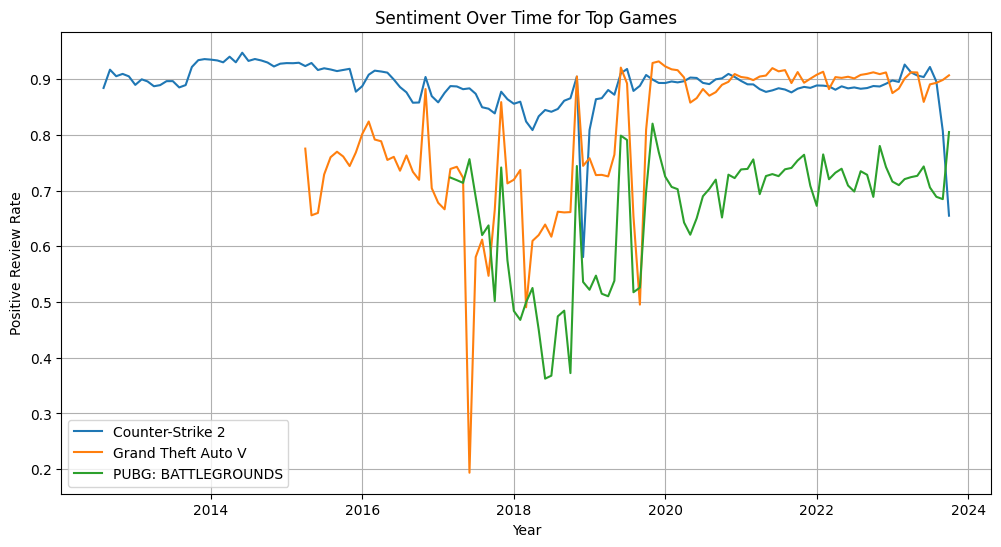

In [10]:
df_top_sentiment = con.execute("""
    SELECT
        game,
        DATE_TRUNC('month', timestamp_created) AS month,
        AVG(CAST(voted_up AS INT)) AS positive_rate
    FROM parquet_scan(?)
    WHERE
        game = 'Grand Theft Auto V'
        OR game = 'Counter-Strike 2'
        OR game = 'PUBG: BATTLEGROUNDS'
    GROUP BY game, month
    ORDER BY game, month
""", [df]).df()

plt.figure(figsize=(12,6))
for g in df_top_sentiment["game"].unique():
    subset = df_top_sentiment[df_top_sentiment["game"] == g]
    plt.plot(subset["month"], subset["positive_rate"], label = g)

plt.legend()
plt.title("Sentiment Over Time for Top Games")
plt.xlabel("Year")
plt.ylabel("Positive Review Rate")
plt.grid(True)
plt.show()

## 5. Player Engagement During Controversy Periods (Key Result)

To test the hypothesis, player engagement was measured using playtime hours and compared across:
- Dip Periods (controversy months)
- Normal Periods
- Positive vs Negative reviews

### Summary of Results


| Period Type   | Sentiment | Median Playtime at Review (Hours) | Average Playtime at Review (Hours) | Median Playtime Total (Hours)  | Average Playtime Total (Hours)   |
|---------------|-----------|-----------------------------------|------------------------------------|--------------------------------|----------------------------------|
| Dip Period    | Negative  | ~87 hours                         | ~319 hours                         | ~146 hours                     | ~483 hours                       |
| Dip Period    | Positive  | ~50 hours                         | ~213 hours                         | ~154 hours                     | ~484 hours                       |
| Normal Period | Negative  | ~7.6 hours                        | ~123 hours                         | ~13 hours                      | ~206 hours                       |
| Normal Period | Positive  | ~17.4 hours                       | ~116 hours                         | ~43 hours                      | ~256 hours                       |



For this analysis using playtime at review instead of lifetime playtime is methodologically important because lifetime playtime includes gameplay that occurs after a review is written, which can artificially inflate engagement measures and obscure behavioral differences at the time of sentiment expression, so I am going to be primarily focusing on this metric for comparing the groups. These results indicate that negative reviews during controversy periods are associated with extremely high engagement levels. Notably, the median playtime at review of negative reviewers during dip periods (~87 hours) was substantially higher than that of negative reviewers during normal periods (~7.6 hours), indicating that controversy-driven negative sentiment is primarily expressed by highly engaged players rather than casual users. So usual negative sentiment during games normal review periods appears to be primarily made out of those that had picked up gaming briefly didn't like it and left (as we can see the overall playtime for the negative normal period is low), then leaving a negative review. Whereas in the dip periods, these cause responses from hardcore gamers that are probably very involved in the community and are leaving reviews to express their frustrations to the game.

Furthermore, the playtime levels of negative and positive reviewers during dip periods were nearly identical, suggesting that these controversy periods bring in the whole community which causes those that agree with the games decisions to leave positive reviews, not just community backlash.

In order to further look into this though, if there is actually a difference in the periods like it appears, I am going to do some statistical analysis on this to find if there is a significant difference and that it is not by chance alone.

## 6. Statistical Analysis

To do the statistical analysis I used a stratified random sampling approach. Specifically, reviews were grouped by `period_type` (Dip vs Normal) and `voted_up` (Positive vs Negative), and then a fixed number of observations (50,000) were randomly sampled from each group using the `PARTITION BY` function and then using a row number selection function `ORDER BY RANDOM()` to make sure the sampling was random and balanced across the dataset. The log transformation was necessary as the original distribution of these were extremely right skewed so the ANOVA wouldn't have avoided bias that would otherwise occur, while still maintaining statistical validity given the large sample size of 200,000 in total.

Here are the distributions of the playtime at review and the log transformed playtime at review for the samples (large enough samples that sample distributions follow population distributions)

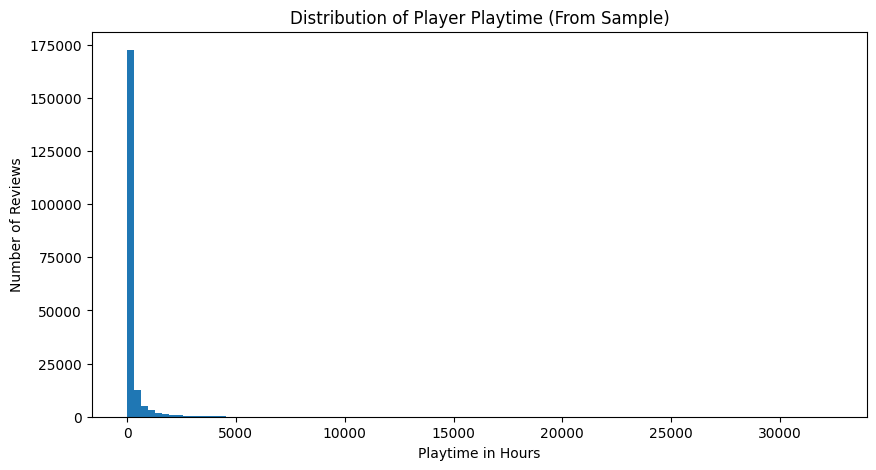

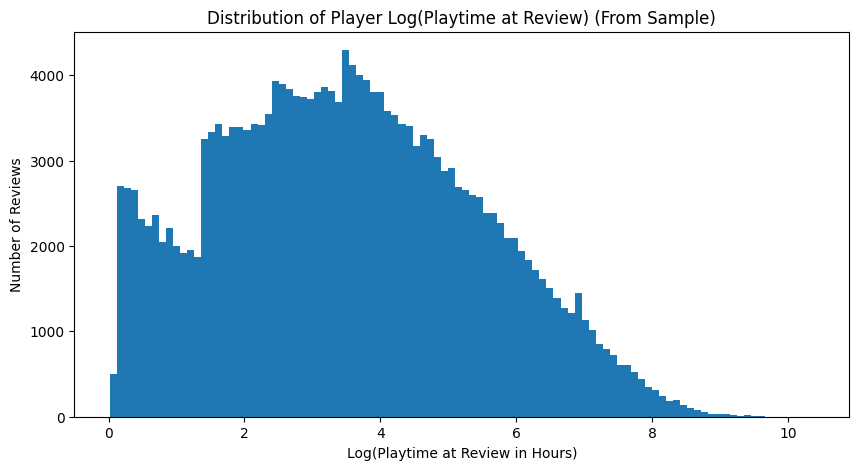

In [22]:
df_dips = con.execute("""
WITH monthly AS (
    SELECT 
        game,
        DATE_TRUNC('month', timestamp_created) AS month,
        AVG(CAST(voted_up AS INT)) AS positive_rate,
        COUNT(*) AS n_reviews
    FROM parquet_scan(?)
    GROUP BY game, month
),
lagged AS (
    SELECT *,
           LAG(positive_rate) OVER (PARTITION BY game ORDER BY month) AS prev_rate
    FROM monthly
)
SELECT *,
       (positive_rate - prev_rate) AS sentiment_change
FROM lagged
WHERE 
    prev_rate IS NOT NULL
    AND n_reviews >= 5000
    AND (positive_rate - prev_rate) <= -0.15
ORDER BY sentiment_change ASC
""", [df]).df()

con.register("dips", df_dips)


df_engagement = con.execute("""
WITH review_data AS (
    SELECT
        game,
        DATE_TRUNC('month', timestamp_created) AS month,
        voted_up,
        author_playtime_at_review / 60.0 AS playtime_hours
    FROM parquet_scan(?)
    WHERE author_playtime_at_review IS NOT NULL AND author_playtime_at_review > 0
),

labeled AS (
    SELECT 
        r.*,
        CASE 
            WHEN (r.game, r.month) IN (SELECT game, month FROM dips)
            THEN 'Dip Period'
            ELSE 'Normal Period'
        END AS period_type
    FROM review_data r
),

sampled AS (
    SELECT *
    FROM (
        SELECT *,
               ROW_NUMBER() OVER (
                   PARTITION BY period_type, voted_up
                   ORDER BY RANDOM()
               ) AS rn
        FROM labeled
    )
    WHERE rn <= 50000
)

SELECT 
    period_type,
    voted_up,
    playtime_hours
FROM sampled
""", [df]).df()

plt.figure(figsize=(10,5))
plt.hist(df_engagement['playtime_hours'], bins = 100)
plt.xlabel("Playtime in Hours")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Player Playtime (From Sample)")
plt.show()

df_engagement["log_playtime"] = np.log1p(df_engagement["playtime_hours"])

plt.figure(figsize=(10,5))
plt.hist(df_engagement['log_playtime'], bins = 100)
plt.xlabel("Log(Playtime at Review in Hours)")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Player Log(Playtime at Review) (From Sample)")
plt.show()

### ANOVA Results: Log Playtime at Review

Two-way ANOVA was performed with:
- Dependent Variable: `log(playtime at review)`
- Factors: `Period Type (Dip vs Normal)` -- `Sentiment (Positive vs Negative)` -- `Period x Sentiment Interaction`

| Source                         | Sum of Squares | df       | F Statistic | p-value        |
|--------------------------------|---------------:|---------:|------------:|----------------|
| Period Type                    | 90,571.77      | 1        | 29,085.53   | < 0.001        |
| Sentiment (voted_up)           | 905.57         | 1        | 290.81      | < 0.001        |
| Period x Sentiment Interaction | 9,645.47       | 1        | 3,097.47    | < 0.001        |
| Residual                       | 622,783.65     | 199,996  | —           | —              |

Due to the small p-values of < .001 which is less than the alpha level of .05 the results indicate that player engagement (playtime at review) differs significantly between Dip and Normal periods, between positive and negative reviews, and that the effect of sentiment depends on whether the review occurred during a controversy period.


### Tukey HSD Post-Hoc Pairwise Comparisons (Log Playtime)

Group labels are defined as:
- Dip Period_False = Negative reviews during Dip Periods  
- Dip Period_True = Positive reviews during Dip Periods  
- Normal Period_False = Negative reviews during Normal Periods  
- Normal Period_True = Positive reviews during Normal Periods  

| Comparison                         | Mean Difference | p-adj | Lower CI | Upper CI | Significant |
|------------------------------------|----------------:|------:|---------:|---------:|-------------|
| Dip Period (Negative) vs Dip Period (Positive) | -0.3046 | < 0.001 | -0.3333 | -0.2760 | Yes |
| Dip Period (Negative) vs Normal Period (Negative) | -1.7851 | < 0.001 | -1.8138 | -1.7564 | Yes |
| Dip Period (Negative) vs Normal Period (Positive) | -1.2113 | < 0.001 | -1.2400 | -1.1826 | Yes |
| Dip Period (Positive) vs Normal Period (Negative) | -1.4805 | < 0.001 | -1.5091 | -1.4518 | Yes |
| Dip Period (Positive) vs Normal Period (Positive) | -0.9067 | < 0.001 | -0.9354 | -0.8780 | Yes |
| Normal Period (Negative) vs Normal Period (Positive) | 0.5738 | < 0.001 | 0.5451 | 0.6025 | Yes |

The Tukey results show that all group pairs are significantly different. Most importantly, both positive and negative reviews during Dip Periods have significantly higher engagement than reviews during Normal Periods, reinforcing that controversy periods are driven by highly engaged players rather than casual or short-term players.

## 7. Interpretation of Findings

The findings strongly support the hypothesis that negative sentiment spikes are primarily driven by highly engaged players rather than casual or low-playtime users. Instead of reflecting disengagement, controversy periods are characterized by reviews from players with substantially higher playtime at the moment of review, indicating continued investment in the game despite dissatisfaction.

This pattern aligns closely with what gamers face being frustrated loyalty, where long-term players critique games they are deeply invested in rather than simply leaving. In contrast, negative reviews during normal periods were associated with significantly lower playtime at review, suggesting that routine negative sentiment is more likely to come from less engaged or short-term players.

Another thing to note is that edited reviews were found to be more negative on average than non-edited reviews during normal periods, which may indicate that more invested players are more likely to revisit and update their feedback over time as their experience with the game evolves.

However, during controversy periods, edited and non-edited reviews exhibited nearly identical sentiment (~51% positive), suggesting that large-scale backlash events affect the overall community similarly regardless of whether reviews are later updated.

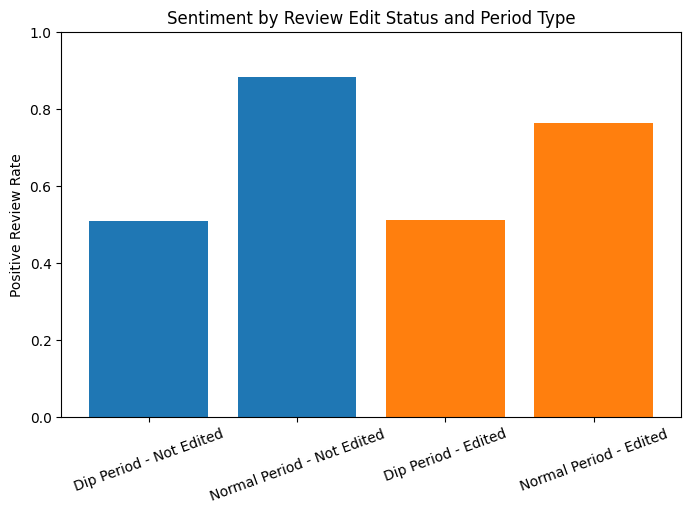

In [19]:
edit_sentiment_period = con.execute(""" 
WITH 
g AS (
    SELECT
        game,
        DATE_TRUNC('month', timestamp_created) as month,
        voted_up,
        is_edited
    FROM parquet_scan(?)
),

labeled AS (
    SELECT 
        g.*,
        CASE 
            WHEN (g.game, g.month) IN (SELECT game, month FROM dips)
            THEN 'Dip Period'
            ELSE 'Normal Period'
        END AS period_type
    FROM g
)
SELECT
    period_type,
    is_edited,
    AVG(CAST(voted_up AS INT)) as positive_rate
FROM labeled
GROUP BY period_type, is_edited
ORDER BY period_type, is_edited
""", [df]).df()

edit_sentiment_period["edit_label"] = edit_sentiment_period["is_edited"].map({
    True: "Edited",
    False: "Not Edited"
})

# Plot grouped bar chart
plt.figure(figsize=(8,5))

for edit_status in edit_sentiment_period["edit_label"].unique():
    subset = edit_sentiment_period[
        edit_sentiment_period["edit_label"] == edit_status
    ]
    plt.bar(
        subset["period_type"] + " - " + edit_status,
        subset["positive_rate"],
        label=edit_status
    )

plt.ylabel("Positive Review Rate")
plt.title("Sentiment by Review Edit Status and Period Type")
plt.ylim(0, 1)
plt.xticks(rotation=20)
plt.show()

## 8. Dataset Limitations

One important limitation of the dataset is that the variable `author_last_played` reflects a user’s most recent activity on Steam rather than continued engagement with the specific game reviewed. As a result, post-review activity cannot be interpreted as continued gameplay of the reviewed title.

Additionally, Steam review data does not preserve full revision histories. When a user edits a review, the original sentiment is overwritten rather than stored as a new record. Therefore, it is not possible to directly observe sentiment transitions (negative to positive) at the individual user level.

To address these limitations, this analysis focuses primarily on playtime accumulated at the time of review and overall engagement levels rather than attempting to infer exact post-review gameplay behavior.


## 9. Conclusion

This study provides strong evidence that negative review spikes are not driven by disengaged or new players, but by highly engaged users with substantial playtime leaving reviews during controversy periods. The large difference in median playtime between dip-period negative reviews and normal-period negative reviews suggests that backlash events amplify feedback from invested community members rather than just casual players.

These findings challenge a common assumption that negative sentiment just reflects player abandonment which is probably the case in the normal-period which is why the negative reviews have such low playtime hours at time of review and also all time playtime hours. But instead, the results indicate that controversy driven negative reviews should be interpreted as signals of engaged frustration rather than disengagement, meaning that these negative review periods are made up of commited players loyal to their game expressing their frustration.

From a broader perspective, this suggests that developers analyzing large scale review data should consider engagement metrics alongside sentiment, as negative feedback from highly invested players may represent valuable long-term user perspectives for what is upsetting the community of the game. While keeping new players is important, it would be beneficial for developers to look into both of these types of negative reviews to accommodate for all reasons players are dissatisfied, as general negative feedback metrics only represents the newer player base.